<a href="https://colab.research.google.com/github/sangar-si/ImageSegmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and extract dataset

In [ ]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle/kaggle.json /root/.kaggle/kaggle.json
# !kaggle competitions download -c carvana-image-masking-challenge
# !cp /content/drive/MyDrive/extract.sh /content/extract.sh
# !sh extract.sh

In [2]:
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
from torch.optim import Adam, SGD, RMSprop
import torch
from torch.utils.data import Dataset, random_split, DataLoader

import matplotlib.pylab as plt
import numpy as np
import cv2
from os import listdir
from os.path import splitext
from pathlib import Path
from PIL import Image
from tqdm import tqdm

In [3]:
df = pd.read_csv('metadata.csv')

# Dataset class

### A Class to work with the dataset.

A data sample contains an image and a mask. Each sample has a unique ID based on file name. We need to define __getitem__ based on the nature of our dataset. In this case, we have an image and it's corresponding mask.

Additionally, we have also defined methods for preprocessing in case we need to subject the input to any type of preprocessing prior to encode. One common preprocessing that is done is downscaling.



In [23]:
images_dir = "./train"
mask_dir = "./train_masks"
img_path = Path(images_dir)

class LoadData(Dataset):
  def __init__(self,img_path, mask_path, scale = 1):
    self.img_path = Path(img_path)
    self.mask_path = Path(mask_path)
    self.scale = scale
    self.img_id = [splitext(f)[0] for f in listdir(img_path) if not f.startswith(".")]

  def __len__(self):
    return len(self.img_id)

  def __getitem__(self, idx):
    name = self.img_id[idx]
    mask_file = list(self.mask_path.glob(name +"_mask" +'.*'))
    img_file = list(self.img_path.glob(name+'.*'))
    mask = self.load(mask_file[0])
    img = self.load(img_file[0])
    mask = self.preprocess(img = mask, scale = self.scale, is_mask = True)
    img = self.preprocess(img = img, scale = self.scale, is_mask = False)

    return {
        'image': torch.as_tensor(img.copy()).float().contiguous(),
        'mask' : torch.as_tensor(mask.copy()).long().contiguous()
    }
  @classmethod
  def load(cls,filename):
    return Image.open(filename)

  @classmethod
  def preprocess(cls,img,scale,is_mask):
    w, h = img.size
    new_w, new_h = int(w * scale), int(h * scale)
    img = img.resize((new_w, new_h), resample=Image.NEAREST if is_mask else Image.BICUBIC)
    img_arr = np.asarray(img)
    if img_arr.ndim == 2 and not is_mask:
      img_arr = img_arr[np.newaxis, ...]
    elif not is_mask:
      img_Arr = img_arr.transpose((2,0,1))
    if not is_mask:
      img_arr = img_arr / 255
    return img_arr


In [7]:
ds = LoadData(img_path = images_dir, scale = 0.5, mask_path= mask_dir)

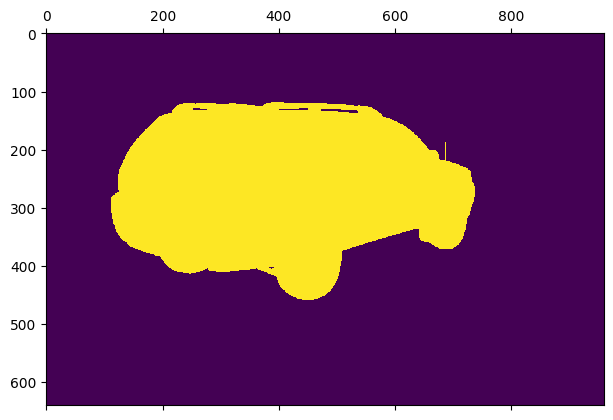

In [8]:
import matplotlib.pyplot as plt

plt.matshow(np.asarray(ds[1]['mask']))
plt.show()

# UNet model definition

We define A UNet model which is an autoencoder type of model where the encoder and decoders are mirror images of each other in terms of architecture.

We generally define a model as an object. In this case, we have separate objects for encoder and decoder. 

CNNs are primarily composed on a set of layers. Most common operations involved are convolution, activation and pooling.

Convolution involves applying a kernel (NxN) across all channels of the input and summed up. The size of the output is computed using the following formula,
Output Size = ((Input Size - Filter Size + 2 * Padding) / Stride) + 1
By default padding is set to 0 and stride is set to 1. Convolution is applied to all channels of the input. The number of channels in the output is decided by the number of kernels we have on a specific layer. For instance, if we apply 10 (3x3) kernels to an input image of size (1920x1080x3) with stride = 1 and padding = 1, output will be 1920x1080x10. The values that make up these kernels are learnt through back propagation during training.

Output of convolution is subjected to activation function, ReLU being the most popular one.

Pooling  helps us to aggregate most significant features. Pooling may involve Max, Sum or Average operations. Max pooling is the most popular method of choice as it helps us aggregate the dominant features and propagate them further down the network. It is usually done using 2x2 kernel with a stride of 2. Pooling doesn't containing any learnable parameters. 

For applications such as image classification or object detection, the intermediate feature maps of a CNN are flattened and passed as input to fully connected (dense) layers for class prediction. In such cases, the input dimensions must be kept constant, since the size of the flattened vector depends directly on the input resolution.

Fully Convolutional Neural Networks (FCNs) are a special class of CNNs that, by design, are agnostic to input dimensions. They do not contain any fully connected layers; instead, they are composed entirely of convolutional (and optionally pooling or upsampling) layers. This allows them to process variable-sized inputs and still produce meaningful outputs, making them particularly useful for tasks such as semantic segmentation.




In [9]:
#Model

class EnBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.convBlock = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(), nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU())
  def forward(self, x):
    return self.convBlock(x)

class Encoder(nn.Module):
  def __init__(self, chnls = (3,64,128,256,512,1024)):
    super().__init__()
    self.en_blocks = nn.ModuleList([EnBlock(chnls[i], chnls[i+1]) for i in range(len(chnls)-1)])
    self.pool = nn.MaxPool2d(2)

  def forward(self,x):
    enc_features = []
    for block in self.en_blocks:
      x = block(x)
      enc_features.append(x)
      x = self.pool(x)
    return enc_features

class DeBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.upConv = nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
    self.decBlock = EnBlock(in_ch, out_ch)

  def crop(self, enc_features, x):
    _,_,h,w = x.shape
    enc_features   = torchvision.transforms.CenterCrop([h, w])(enc_features) 
    return x, enc_features

  def pad(self, enc_features, x):
    _,_,hx,wx = x.shape
    _,_,henc,wenc = enc_features.shape
    hdiff = henc - hx
    wdiff = wenc - wx
    x = F.pad(x, [wdiff // 2, wdiff - wdiff // 2,
                        hdiff // 2, hdiff - hdiff // 2])
    return x, enc_features

  def forward(self, x, enc_features):
    x = self.upConv(x)
    # x, enc_f = self.crop(enc_features,x)
    x, enc_f = self.pad(enc_features, x)
    x = torch.cat([x, enc_f], dim=1)
    x = self.decBlock(x)
    return x

class Decoder(nn.Module):
  def __init__(self, chnls = (1024, 512, 256, 128, 64)):
    super().__init__()
    self.chnls = chnls
    self.de_blocks = nn.ModuleList([DeBlock(chnls[i], chnls[i+1]) for i in range(len(chnls)-1)])

  def forward(self,x,enc_features):
    for i in range(len(self.chnls)-1):
      x = self.de_blocks[i](x, enc_features[i])
    return x

class UNet(nn.Module):
  def __init__(self, enc_chnls = (3,64,128,256,512,1024), dec_chnls = (1024, 512, 256, 128, 64), num_class = 1, retain_dim=False, out_sz=(572,572)):
    super().__init__()
    self.encoder = Encoder(enc_chnls)
    self.decoder = Decoder(dec_chnls)
    self.head = nn.Conv2d(dec_chnls[-1],num_class, 1)
    self.retain_dim = retain_dim
    self.out_sz = out_sz
  
  def forward(self,x):
    enc_features = self.encoder(x)
    out = self.decoder(enc_features[::-1][0], enc_features[::-1][1:])
    out = self.head(out)
    if self.retain_dim:
      out = F.interpolate(out, self.out_sz)
    return out


### Define Loss function

Purpose of this is to evaluate how good our predictions are compared to the training label. Choice of loss function depends on the task we are trying to accomplish. In our case, we are using a combination of Cross Entropy and Dice loss. The loss function has to be differentiable (for back propagation to be possible).

In [31]:

class CEDiceLoss(nn.Module):
  def __init__(self, weights = None, size_average = True):
    super(CEDiceLoss,self).__init__()

  def dice(self, mask_pred, mask_true, smooth=1e-8):
    mask_pred = F.softmax(mask_pred).float()
    mask_true = F.one_hot(mask_true, 2).permute(2, 0, 1).float()
    # print(mask_pred.shape)
    # print(mask_true.shape)
    mask_pred = mask_pred.reshape(-1)
    mask_true = mask_true.reshape(-1)
    intersection = (mask_pred * mask_true).sum()
    dice_loss = 1 - (2 * intersection + smooth) / (mask_pred.sum() + mask_true.sum() + smooth)
    return dice_loss

  def forward(self, mask_pred, mask_true, smooth = 1e-8):
    CELoss = F.cross_entropy(mask_pred, mask_true, reduction='mean')
    dice_sum = 0
    for i in range(mask_pred.shape[0]):
      dice_sum+= self.dice(mask_pred[i,...], mask_true[i,...])
    dice_loss = dice_sum/mask_pred.shape[0]
    # mask_pred = F.softmax(mask_pred)
    # mask_pred = mask_pred.view(-1)
    # mask_true = mask_true.view(-1)
    # intersection = (mask_pred * mask_true).sum()
    # dice_loss = 1 - (2 * intersection + smooth) / (mask_pred.sum() + mask_true.sum() + smooth)
    return CELoss+dice_loss

def dice_score(mask_pred, mask_true, smooth = 1e-8):
  dice_sum = 0.0
  for i in range(mask_pred.shape[0]):
    m_pred = mask_pred[i,...]
    m_true = mask_true[i,...]
    m_pred = F.one_hot(m_pred.argmax(dim = 0), 2).permute(2,0,1).float().reshape(-1)
    m_true = F.one_hot(m_true,2).permute(2,0,1).float().reshape(-1)
    intersection = (m_pred * m_true).sum()
    dice_sum += 1 - (2 * intersection + smooth) / (m_pred.sum() + m_true.sum() + smooth)
  return dice_sum/mask_pred.shape[0]




# Train, eval and predict function

Define the network. If training is to be done in GPU, move the model to GPU.

In [10]:
net = UNet(num_class=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device = device)

UNet(
  (encoder): Encoder(
    (en_blocks): ModuleList(
      (0): EnBlock(
        (convBlock): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (1): EnBlock(
        (convBlock): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (2): EnBlock(
        (convBlock): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (3): EnBlock(
        (convBlock): Sequential(
          (0): Conv2d(256, 512, kernel_size=(3, 3), s

## Model Training

Training code comprises of loading the train split of the dataset. From the training split, we randomly set aside a portion of data for validation. Rule of thumb is to set aside 20% of the training set for validation. It is vital to ensure that the distribution of data in the validation set is similar to that of the training split.

Next, we define the optimizer for the training process. The choice of optimizer directly affects how efficiently and effectively the model learns. While the traditional approach is Gradient Descent, it can be computationally expensive and may not always yield optimal results for complex problems. Other alternatives such as Adam, RMSProp, or Stochastic Gradient Descent (SGD) with momentum are often preferred due to better convergence properties and adaptability.

Another training parameter that we need to pay attention to during training is the learning rate, which decides the quantum of change we make to the model weights based on back propagating the error. Quite often, it is desirable to start with a higher value for learning rate and gradually decrease it over the training period so as to allow fine-tuned learning and to avoid overfitting and divergence. Schedulers are used to accomplish this

In [11]:
def train(net, epochs, batch_size, lr, device, scale, val_percent, amp, save_checkpoint = True):
  images_dir = "./train"
  mask_dir = "./train_masks"
  img_path = Path(images_dir)
  #Load the dataset
  ds = LoadData(img_path = images_dir, scale = scale, mask_path= mask_dir)

  #Create train and validation splits
  n_val = int(len(ds) * val_percent)
  n_train = len(ds) - n_val
  train_set, val_set = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(0))

  #Define batch size. Sometimes, we might encounter errors where we run out of GPU memory during training. Tuning batch size can help mitigate such cases.
  #A large batch size would lead to faster training but consumes more memory during training
  loader_args = dict(batch_size = batch_size, num_workers = 4, pin_memory = True)
  train_loader = DataLoader(train_set, shuffle=True, **loader_args)
  val_loader = DataLoader(val_set, shuffle=False, drop_last = True, **loader_args) 
  #We create dataloader for training and validation set in the above section


  #We define the optimizer.
  optimizer = RMSprop(net.parameters(), lr = lr, weight_decay = 1e-8, momentum = 0.9)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
  # criterion = nn.CrossEntropyLoss()
  criterion = CEDiceLoss()
  global_step = 0
  epoch_loss = 0
  val_score = {}
  for epoch in range(epochs):
    net.train()
    with tqdm(total = n_train, desc = f'Epoch {epoch + 1}/{epochs}', unit = 'img') as pbar:
      for batch in train_loader:
        imgs = batch['image']
        masks = batch['mask']
        imgs = imgs.to(device=device, dtype = torch.float32)
        imgs = torch.permute(imgs,(0,3,1,2))
        masks = masks.to(device=device, dtype = torch.long)

        with torch.cuda.amp.autocast(enabled = amp):
          masks_pred = net(imgs)
          # loss = criterion(masks_pred, masks)\
          #                  + dice_loss(F.softmax(masks_pred, dim=1).float(),
          #                              F.one_hot(masks, net.n_classes).permute(0, 3, 1, 2).float(),
          #                              multiclass=True)
          loss = criterion(masks_pred,masks)
        optimizer.zero_grad(set_to_none = True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        pbar.update(imgs.shape[0])
        global_step +=1
        epoch_loss += loss.item()
        pbar.set_postfix(**{'loss (batch)': loss.item()})

        #Eval
        div_step = (n_train//(10*batch_size))
        if div_step > 0:
          if global_step % div_step == 0:
            val_score = evaluate(net, val_loader, device)
            print("Val score is ", val_score)
            scheduler.step(val_score)
    if save_checkpoint:
      try:
        torch.save(net.state_dict(),"unet"+str(epoch)+".pth")
      except:
        print("Save failed")

def evaluate(net, data_loader, device):
  net.eval()
  dice_score_value = 0
  with tqdm(total = len(data_loader), desc = 'Validation round', unit = 'batch') as pbar: 
  # for batch in tqdm(data_loader, total = len(data_loader), desc = 'Validation round', unit = 'batch'):
    for batch in data_loader:
      imgs, masks = batch['image'], batch['mask']
      imgs = imgs.to(device=device, dtype = torch.float32)
      imgs = torch.permute(imgs,(0,3,1,2))
      masks = masks.to(device=device, dtype = torch.long)
      # masks = F.one_hot(masks, 2).permute(0, 3, 1, 2).float()

      with torch.no_grad():
        mask_pred = net(imgs)
        dice_score_value += dice_score(mask_pred, masks)
      pbar.update(1)
      pbar.set_postfix(**{'dice score (batch)': dice_score(mask_pred, masks)})
  net.train()
  return dice_score_value/len(data_loader)


In [12]:
train(net=net, epochs = 5, batch_size = 3, lr = 0.00001, device = device, scale = 0.5, val_percent = 10/100, amp = False)

/tmp/ipykernel_465418/2320126096.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
Epoch 1/5:   0%|          | 0/4580 [00:00<?, ?img/s]/tmp/ipykernel_465418/2320126096.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled = amp):
/tmp/ipykernel_465418/496054771.py:85: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mask_pred = F.softmax(mask_pred).float()
Epoch 1/5:  10%|█         | 459/4580 [01:32<3:09:13,  2.75s/img, loss (batch)=0.401]

Val score is  tensor(0.1402, device='cuda:0')


Epoch 1/5:  20%|█▉        | 915/4580 [03:04<2:51:42,  2.81s/img, loss (batch)=0.49]

Val score is  tensor(0.0920, device='cuda:0')


Epoch 1/5:  30%|██▉       | 1371/4580 [04:35<2:40:01,  2.99s/img, loss (batch)=0.224]

Val score is  tensor(0.0609, device='cuda:0')


Epoch 1/5:  40%|███▉      | 1827/4580 [06:04<2:08:51,  2.81s/img, loss (batch)=0.0802]

Val score is  tensor(0.0304, device='cuda:0')


Epoch 1/5:  50%|████▉     | 2283/4580 [07:34<1:53:58,  2.98s/img, loss (batch)=0.076]

Val score is  tensor(0.0239, device='cuda:0')


Epoch 1/5:  60%|█████▉    | 2739/4580 [09:04<1:29:57,  2.93s/img, loss (batch)=0.115]

Val score is  tensor(0.0259, device='cuda:0')


Epoch 1/5:  70%|██████▉   | 3195/4580 [10:36<1:12:30,  3.14s/img, loss (batch)=0.0802]

Val score is  tensor(0.0215, device='cuda:0')


Epoch 1/5:  80%|███████▉  | 3651/4580 [12:11<56:15,  3.63s/img, loss (batch)=0.0523]

Val score is  tensor(0.0199, device='cuda:0')


Epoch 1/5:  90%|████████▉ | 4107/4580 [13:55<33:18,  4.23s/img, loss (batch)=0.0938]

Val score is  tensor(0.0198, device='cuda:0')


Epoch 1/5: 100%|█████████▉| 4563/4580 [15:26<00:49,  2.89s/img, loss (batch)=0.0888]

Val score is  tensor(0.0195, device='cuda:0')


Epoch 2/5:  10%|▉         | 438/4580 [01:44<5:16:04,  4.58s/img, loss (batch)=0.0625]

Val score is  tensor(0.0195, device='cuda:0')


Epoch 2/5:  20%|█▉        | 894/4580 [03:21<3:37:16,  3.54s/img, loss (batch)=0.0799]

Val score is  tensor(0.0195, device='cuda:0')


Epoch 2/5:  29%|██▉       | 1350/4580 [05:01<3:25:17,  3.81s/img, loss (batch)=0.0792]

Val score is  tensor(0.0195, device='cuda:0')


Epoch 2/5:  39%|███▉      | 1806/4580 [06:43<3:09:46,  4.10s/img, loss (batch)=0.0777]

Val score is  tensor(0.0195, device='cuda:0')


Epoch 2/5:  49%|████▉     | 2262/4580 [08:19<2:10:46,  3.39s/img, loss (batch)=0.0751]

Val score is  tensor(0.0195, device='cuda:0')


Epoch 2/5:  59%|█████▉    | 2718/4580 [09:54<1:43:56,  3.35s/img, loss (batch)=0.0483]

Val score is  tensor(0.0194, device='cuda:0')


Epoch 2/5:  69%|██████▉   | 3174/4580 [11:33<1:28:48,  3.79s/img, loss (batch)=0.0714]

Val score is  tensor(0.0194, device='cuda:0')


Epoch 2/5:  79%|███████▉  | 3630/4580 [13:11<58:17,  3.68s/img, loss (batch)=0.0541]

Val score is  tensor(0.0194, device='cuda:0')


Epoch 2/5:  89%|████████▉ | 4086/4580 [14:49<29:28,  3.58s/img, loss (batch)=0.0765]

Val score is  tensor(0.0194, device='cuda:0')


Epoch 2/5:  99%|█████████▉| 4542/4580 [16:22<02:06,  3.32s/img, loss (batch)=0.0814]

Val score is  tensor(0.0194, device='cuda:0')


Epoch 3/5:   9%|▉         | 417/4580 [01:29<3:56:32,  3.41s/img, loss (batch)=0.0574]

Val score is  tensor(0.0194, device='cuda:0')


Epoch 3/5:  19%|█▉        | 873/4580 [03:04<3:23:44,  3.30s/img, loss (batch)=0.0989]

Val score is  tensor(0.0193, device='cuda:0')


Epoch 3/5:  29%|██▉       | 1329/4580 [04:37<2:50:18,  3.14s/img, loss (batch)=0.0503]

Val score is  tensor(0.0193, device='cuda:0')


Epoch 3/5:  39%|███▉      | 1785/4580 [06:09<2:25:41,  3.13s/img, loss (batch)=0.087]

Val score is  tensor(0.0193, device='cuda:0')


Epoch 3/5:  49%|████▉     | 2241/4580 [07:40<1:56:18,  2.98s/img, loss (batch)=0.0632]

Val score is  tensor(0.0193, device='cuda:0')


Epoch 3/5:  59%|█████▉    | 2697/4580 [09:17<1:52:32,  3.59s/img, loss (batch)=0.0544]

Val score is  tensor(0.0192, device='cuda:0')


Epoch 3/5:  69%|██████▉   | 3153/4580 [10:52<1:18:58,  3.32s/img, loss (batch)=0.0914]

Val score is  tensor(0.0192, device='cuda:0')


Epoch 3/5:  79%|███████▉  | 3609/4580 [12:27<54:47,  3.39s/img, loss (batch)=0.0423]

Val score is  tensor(0.0192, device='cuda:0')


Epoch 3/5:  89%|████████▉ | 4065/4580 [13:58<25:04,  2.92s/img, loss (batch)=0.0646]

Val score is  tensor(0.0193, device='cuda:0')


Epoch 3/5:  99%|█████████▊| 4521/4580 [15:35<03:27,  3.51s/img, loss (batch)=0.0752]

Val score is  tensor(0.0192, device='cuda:0')


Epoch 4/5:   9%|▊         | 396/4580 [01:25<3:54:55,  3.37s/img, loss (batch)=0.0562]

Val score is  tensor(0.0192, device='cuda:0')


Epoch 4/5:  19%|█▊        | 852/4580 [03:06<4:05:06,  3.94s/img, loss (batch)=0.0493]

Val score is  tensor(0.0192, device='cuda:0')


Epoch 4/5:  29%|██▊       | 1308/4580 [04:43<3:10:33,  3.49s/img, loss (batch)=0.0743]

Val score is  tensor(0.0191, device='cuda:0')


Epoch 4/5:  39%|███▊      | 1764/4580 [06:19<2:44:31,  3.51s/img, loss (batch)=0.119]

Val score is  tensor(0.0191, device='cuda:0')


Epoch 4/5:  48%|████▊     | 2220/4580 [07:56<2:18:58,  3.53s/img, loss (batch)=0.084]

Val score is  tensor(0.0191, device='cuda:0')


Epoch 4/5:  58%|█████▊    | 2676/4580 [09:35<1:58:10,  3.72s/img, loss (batch)=0.0977]

Val score is  tensor(0.0191, device='cuda:0')


Epoch 4/5:  68%|██████▊   | 3132/4580 [11:13<1:31:13,  3.78s/img, loss (batch)=0.134]

Val score is  tensor(0.0191, device='cuda:0')


Epoch 4/5:  78%|███████▊  | 3588/4580 [13:02<1:21:42,  4.94s/img, loss (batch)=0.0837]

Val score is  tensor(0.0191, device='cuda:0')


Epoch 4/5:  88%|████████▊ | 4044/4580 [14:36<29:36,  3.31s/img, loss (batch)=0.0745]

Val score is  tensor(0.0190, device='cuda:0')


Epoch 4/5:  98%|█████████▊| 4500/4580 [16:14<05:05,  3.81s/img, loss (batch)=0.0711]

Val score is  tensor(0.0190, device='cuda:0')


Epoch 5/5:   8%|▊         | 375/4580 [01:40<6:01:06,  5.15s/img, loss (batch)=0.0975]

Val score is  tensor(0.0190, device='cuda:0')


Epoch 5/5:  18%|█▊        | 831/4580 [03:15<3:29:03,  3.35s/img, loss (batch)=0.0717]

Val score is  tensor(0.0190, device='cuda:0')


Epoch 5/5:  28%|██▊       | 1287/4580 [04:52<3:19:11,  3.63s/img, loss (batch)=0.0715]

Val score is  tensor(0.0190, device='cuda:0')


Epoch 5/5:  38%|███▊      | 1743/4580 [06:26<2:30:13,  3.18s/img, loss (batch)=0.0515]

Val score is  tensor(0.0190, device='cuda:0')


Epoch 5/5:  48%|████▊     | 2199/4580 [07:58<2:01:32,  3.06s/img, loss (batch)=0.0853]

Val score is  tensor(0.0190, device='cuda:0')


Epoch 5/5:  58%|█████▊    | 2655/4580 [09:31<1:41:16,  3.16s/img, loss (batch)=0.06]

Val score is  tensor(0.0189, device='cuda:0')


Epoch 5/5:  68%|██████▊   | 3111/4580 [11:24<2:03:39,  5.05s/img, loss (batch)=0.0676]

Val score is  tensor(0.0189, device='cuda:0')


Epoch 5/5:  78%|███████▊  | 3567/4580 [13:00<57:44,  3.42s/img, loss (batch)=0.079]

Val score is  tensor(0.0189, device='cuda:0')


Epoch 5/5:  88%|████████▊ | 4023/4580 [14:37<32:17,  3.48s/img, loss (batch)=0.0956]

Val score is  tensor(0.0189, device='cuda:0')


Epoch 5/5:  98%|█████████▊| 4479/4580 [16:16<06:06,  3.63s/img, loss (batch)=0.074]

Val score is  tensor(0.0189, device='cuda:0')


Epoch 5/5: 100%|██████████| 4580/4580 [16:29<00:00,  4.63img/s, loss (batch)=0.0548]


In [13]:
def predict(net, image, device, disp = False):
  net.eval()
  image = image.to(device = device, dtype = torch.float32)

  image = image[None,:]
  image = torch.permute(image, (0,3,1,2))

  with torch.no_grad():
    m_pred = net(image)
  m_pred = m_pred[0,...].argmax(dim=0).to(device = 'cpu', dtype = torch.long)
  if disp:
    plt.matshow(np.asarray(m_pred))
    plt.title("Predicted mask")
    plt.show()
  return m_pred

def display_mask(mask, title = "Original mask"):
  plt.matshow(np.asarray(mask))
  plt.title(title)
  plt.show()

def display_img(img, title = "Original image"):
  plt.imshow(np.asarray(img))
  plt.title(title)

def display_result(img, act, pred):
  import matplotlib
  matplotlib.rcParams['figure.figsize'] = [25, 15]
  fig, axs = plt.subplots(1, 3)
  axs[0].imshow(np.asarray(img))
  axs[0].set_title("Original Image")
  axs[1].matshow(np.asarray(act))
  axs[1].set_title("Actual Mask")
  axs[2].matshow(np.asarray(pred))
  axs[2].set_title("Predicted Mask")

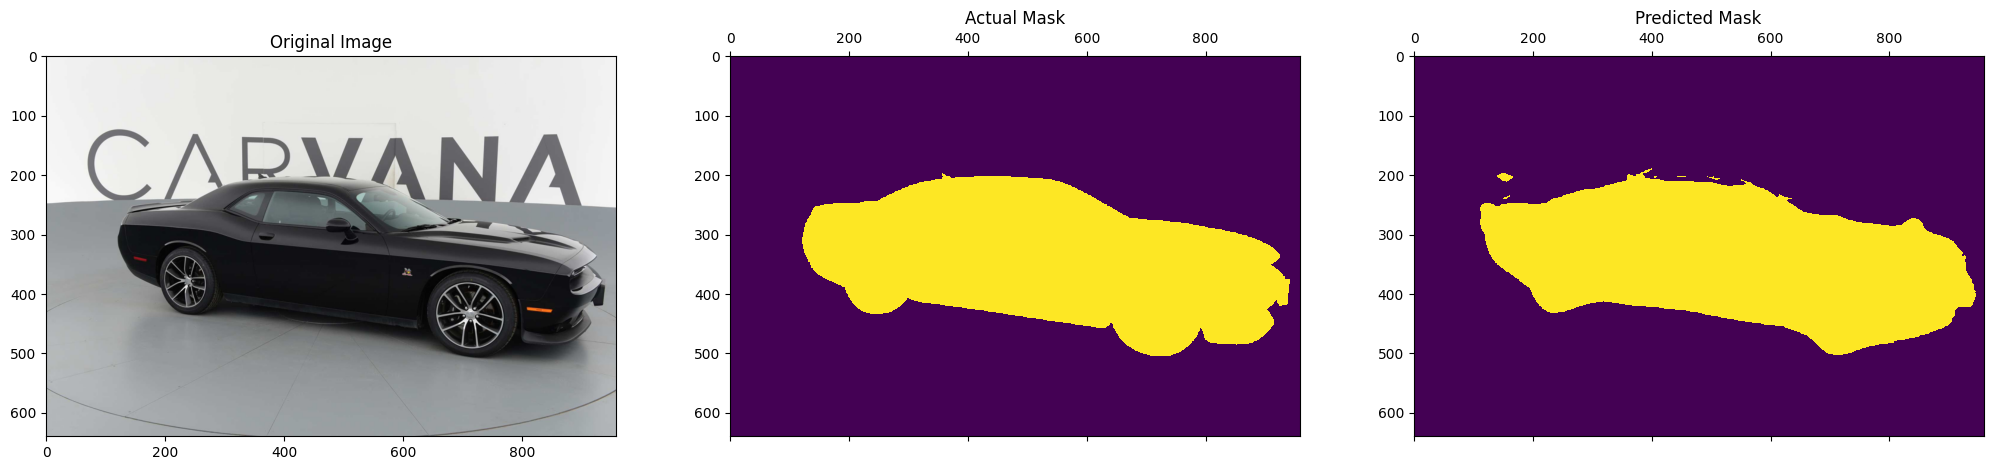

In [18]:
images_dir = "./train"
mask_dir = "./train_masks"
test_dir = "./test"
img_path = Path(images_dir)
ds = LoadData(img_path = images_dir, scale = 0.5, mask_path= mask_dir)
n_val = int(len(ds) * 0.1)
n_train = len(ds) - n_val
train_set, val_set = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(0))
batch_size = 5
loader_args = dict(batch_size = batch_size, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_set, shuffle=False, drop_last = True, **loader_args)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
idx = 23
test_image = val_set[idx]
test_img = test_image['image']
test_mask = test_image['mask']
m_pred = predict(net, test_img, device)
display_result(test_img, test_mask, m_pred)